In [32]:
import os
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
import pydicom as dcm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, Dense, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow as tf

from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Load the dataset
train_labels = pd.read_csv('labels/stage_2_train_labels.csv')
detailed_class_info = pd.read_csv('labels/stage_2_detailed_class_info.csv')
# Path
PATH = r"C:\Users\PraneelSreekesh\OneDrive - The Software Works Inc\Desktop\Capstone-Project"  # add your directory location like C:\Users\
os.chdir(PATH)

TRAIN_IMAGES = os.path.join(PATH, "stage_2_train_images\\")
TEST_IMAGES = os.path.join(PATH, "stage_2_test_images\\")

# Output files will be stored here
OUTPUT_DIR = os.path.join(PATH, "output\\")
np.random.seed(42)


In [14]:
# Merge the dataframes
merged_df = pd.merge(train_labels, detailed_class_info, on='patientId')
merged_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [6]:
# Check for any missing values
print(merged_df.isnull().sum())

# Extract unique classes
classes = merged_df['class'].unique()
print(classes)


patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
class            0
dtype: int64
['No Lung Opacity / Not Normal' 'Normal' 'Lung Opacity']


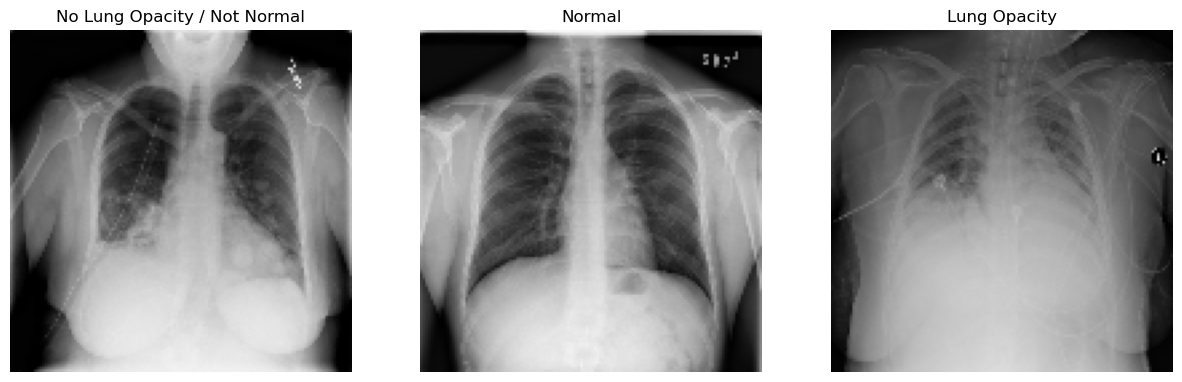

In [15]:
# Define a function to load and preprocess DICOM images
def load_dicom_image(patient_id, image_dir, target_size=(128, 128)):
    dcm_path = os.path.join(image_dir, patient_id + '.dcm')
    dcm_data = pydicom.read_file(dcm_path)
    img = dcm_data.pixel_array
    img = cv2.resize(img, target_size)
    img = np.stack((img,)*3, axis=-1)  # Convert to 3-channel image
    return img

# Plot some images with their classes
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
image_dir = 'stage_2_train_images'

for i, cls in enumerate(classes):
    sample_id = merged_df[merged_df['class'] == cls].iloc[0]['patientId']
    img = load_dicom_image(sample_id, image_dir)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(cls)
    ax[i].axis('off')

plt.show()


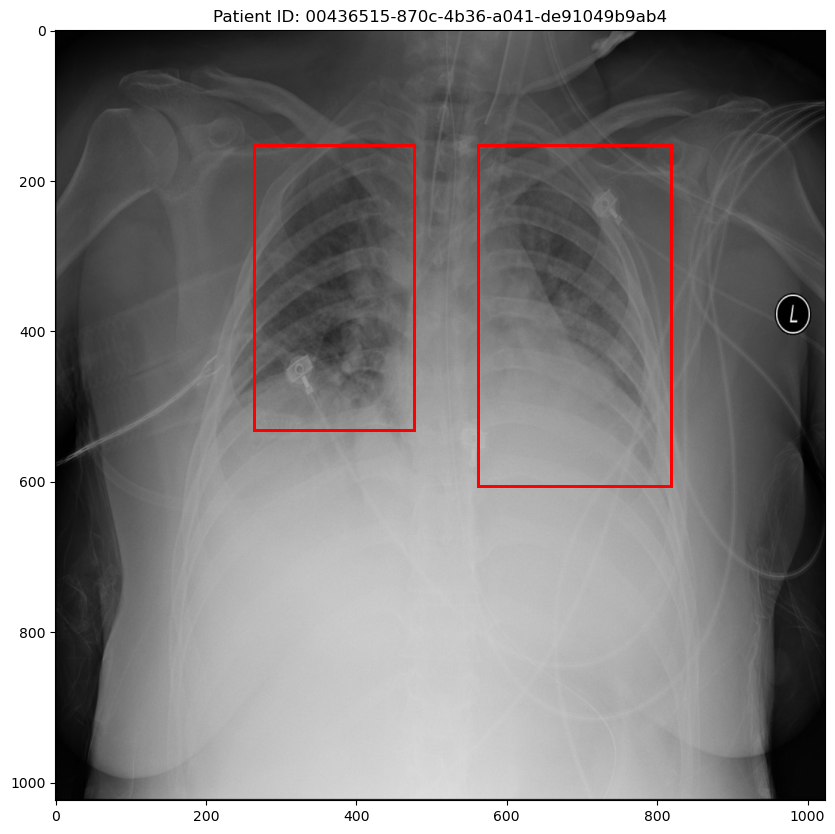

In [16]:
def load_dicom_image(patient_id, image_dir, target_size=(1024, 1024)):
    dcm_path = os.path.join(image_dir, patient_id + '.dcm')
    dcm_data = pydicom.read_file(dcm_path)
    img = dcm_data.pixel_array
    img = cv2.resize(img, target_size)
    img = np.stack((img,) * 3, axis=-1)  # Convert to 3-channel image
    return img
def plot_image_with_bbox(patient_id, image_dir, df):
    img = load_dicom_image(patient_id, image_dir)
    bboxes = df[df['patientId'] == patient_id][['x', 'y', 'width', 'height']].values
    
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img, cmap='gray')
    
    for bbox in bboxes:
        if not np.isnan(bbox).any():  # Check for valid bounding box
            rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    
    plt.title(f'Patient ID: {patient_id}')
    plt.show()
sample_patient_id = merged_df[merged_df['Target'] == 1].iloc[0]['patientId']
plot_image_with_bbox(sample_patient_id, image_dir, merged_df)

In [18]:
# Function to load and preprocess DICOM image
def load_dicom_image(patient_id, image_dir, target_size=(128, 128)):
    dcm_path = os.path.join(image_dir, patient_id + '.dcm')
    dcm_data = pydicom.read_file(dcm_path)
    img = dcm_data.pixel_array
    img = cv2.resize(img, target_size)
    img = np.stack((img,) * 3, axis=-1)  
    return img

In [21]:
image_dir = 'stage_2_train_images\\'
X = np.array([load_dicom_image(pid, image_dir) for pid in merged_df['patientId']])
y = to_categorical(merged_df['Target'])

In [22]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [23]:
# Data augmentation
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, validation_split=0.2)


In [24]:
# Define a basic CNN model
def basic_cnn_model(height, width, num_channels, num_classes):
    model = Sequential()
    model.add(Input(shape=(height, width, num_channels)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax')) 
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = basic_cnn_model(128, 128, 3, 2)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32, subset='training'), 
                    validation_data=datagen.flow(X_train, y_train, batch_size=32, subset='validation'), 
                    epochs=10, verbose=1)

# Evaluate the model
score = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation accuracy: {score[1]}")

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()
model.save('output\\basic_cnn_model.h5')
print("Model saved as 'basic_cnn_model.h5'")

In [27]:
# Load the previously trained model
model = load_model('output\\basic_cnn_model.h5')

# Recompile the model with the same optimizer
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tuning settings
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [42]:
tf.random.set_seed(47)

In [43]:
# Fine-tune the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=[learning_rate_reduction])

# Save the fine-tuned model
model.save('output\\fine_tuned_cnn_model.h5')
print("Fine-tuned model saved as 'fine_tuned_cnn_model.h5'")


Epoch 1/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 229s 243ms/step - accuracy: 0.7070 - loss: 0.5874 - val_accuracy: 0.5474 - val_loss: 0.6826 - learning_rate: 0.0010
Epoch 2/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 194s 207ms/step - accuracy: 0.7100 - loss: 0.5824 - val_accuracy: 0.5723 - val_loss: 0.6725 - learning_rate: 0.0010
Epoch 3/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 219s 233ms/step - accuracy: 0.7121 - loss: 0.5814 - val_accuracy: 0.5068 - val_loss: 0.7045 - learning_rate: 0.0010
Epoch 4/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 243s 258ms/step - accuracy: 0.7132 - loss: 0.5765 - val_accuracy: 0.4907 - val_loss: 0.7276 - learning_rate: 0.0010
Epoch 5/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 244s 259ms/step - accuracy: 0.7188 - loss: 0.5772 - val_accuracy: 0.5942 - val_loss: 0.6591 - learning_rate: 0.0010
Epoch 6/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 245s 261ms/step - accuracy: 0.7183 - loss: 0.5738 - val_accuracy: 0.6040 - val_loss: 0.6548 - learning_rate: 0.0010
Epoch 7/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 250s 265ms/step - accura

Fine-tuned model saved as 'fine_tuned_cnn_model.h5'


236/236 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.5699 - loss: 0.6730
Validation loss: 0.674103319644928
Validation accuracy: 0.568030834197998


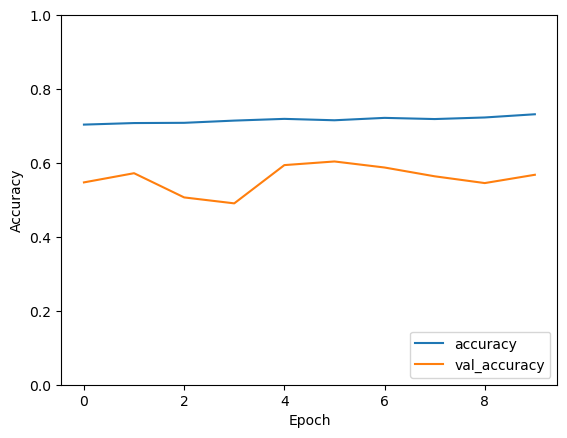

In [44]:
# Evaluate the fine-tuned model
score = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation loss: {score[0]}")
print(f"Validation accuracy: {score[1]}")

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [46]:
# Define the number of classes
num_classes = 3

# Assuming y_train and y_val are your labels
# Ensure that y_train and y_val are numpy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)

datagen_train = ImageDataGenerator(
    rescale=1./255,  # normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen_val = ImageDataGenerator(rescale=1./255) 
batch_size = 32
train_generator = datagen_train.flow(X_train, y_train, batch_size=batch_size)
val_generator = datagen_val.flow(X_val, y_val, batch_size=batch_size)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add new top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(X_val) // batch_size
)

# Save the transfer learning model
model.save('output\\transfer_learning_model.h5')
model.save('output\\transfer_learning_model.keras')


MemoryError: Unable to allocate 5.51 GiB for an array with shape (30103, 128, 128, 3) and data type float32

In [ ]:
import os
import numpy as np
import skimage.io
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn import model as modellib, utils

class PneumoniaDataset(Dataset):
    def load_dataset(self, dataset_dir, is_train=True):
        self.add_class("dataset", 1, "Pneumonia")
        images_dir = os.path.join(dataset_dir, 'images')
        annotations_dir = os.path.join(dataset_dir, 'annotations')

        for filename in os.listdir(images_dir):
            image_id = filename[:-4]
            if is_train and int(image_id) >= 150:
                continue
            if not is_train and int(image_id) < 150:
                continue

            img_path = os.path.join(images_dir, filename)
            ann_path = os.path.join(annotations_dir, image_id + '.json')

            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    def extract_boxes(self, annotation_file):
        import json
        with open(annotation_file) as f:
            data = json.load(f)
        boxes = []
        for box in data['boxes']:
            x1, y1, x2, y2 = box['x1'], box['y1'], box['x2'], box['y2']
            coors = [x1, y1, x2, y2]
            boxes.append(coors)
        width = data['width']
        height = data['height']
        return boxes, width, height

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        boxes, w, h = self.extract_boxes(path)
        masks = np.zeros([h, w, len(boxes)], dtype='uint8')
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
        return masks, np.asarray([1 for _ in range(len(boxes))], dtype='int32')

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# Prepare the train and validation datasets
dataset_train = PneumoniaDataset()
dataset_train.load_dataset('', is_train=True)
dataset_train.prepare()

dataset_val = PneumoniaDataset()
dataset_val.load_dataset('', is_train=False)
dataset_val.prepare()


class PneumoniaConfig(Config):
    NAME = "pneumonia"
    IMAGES_PER_GPU = 2
    NUM_CLASSES = 1 + 1  # Background + pneumonia
    STEPS_PER_EPOCH = 100
    DETECTION_MIN_CONFIDENCE = 0.7

config = PneumoniaConfig()


# Load the Mask R-CNN model pre-trained on COCO
model = modellib.MaskRCNN(mode="training", config=config, model_dir='logs/')
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

# Train the model
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=30,
            layers='heads')

# Save the trained model
model_path = 'mask_rcnn_pneumonia.h5'
model.keras_model.save_weights(model_path)


# Pickle the Model for Future Prediction
import pickle

# Save the fine-tuned model
with open('fine_tuned_cnn_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Load the model
with open('fine_tuned_cnn_model.pkl', 'rb') as f:
    model = pickle.load(f)